# Vibrational strong coupling of liquid water in a Bragg resonator: Unix socket

**Authors: Xinwei Ji, Tao E. Li**

Here, we introduce how to use MaxwellLink to run classical molecular dynamics (LAMMPS) simulations of liquid water under vibrational strong coupling by connecting MEEP FDTD with LAMMPS.

## 1. Run with realistic Bragg resonator

Let's try to setup our simulation for an abstract `Molecule` confined at the center of a Bragg resonator in 1D. 

This Bragg resonator is composed of a pair of parallel mirrors spaced by $\lambda/2$, each of which consists of five periodic dielectric layers. The spacing between the neighboring dielectric layer is $\lambda/4$. With the refrative index of each dielectric layer as $n=2$, each dielectric layer possesses a thickness of $\lambda/8$. This Bragg resonator supports a resonant cavity mode at wavelength $\lambda$.

We also artifically enhance the current density of this abstract `Molecule` by a factor of `rescaling_factor=1e5`, so that strong coupling can form for a small ensemble of molecules coupled to the optical cavity. This abstract `Molecule` is connected to the MEEP FDTD solver via the Unix socket in local machines.

In [1]:
import numpy as np
import maxwelllink as mxl
import meep as mp

address = "socket_cavmd"
hub = mxl.SocketHub(unixsocket=address, timeout=10.0, latency=1e-5)

resolution = 20
time_units_fs = 20
rescaling = 0.47

# geometry 1: 1d bragg resonator
pml_thickness = 2.0 * rescaling
t1 = 0.125 * rescaling
t2 = 0.25 * rescaling
n1 = 2.0
n2 = 1.0

nlayer = 5
layer_indexes = np.array([n2, n1] * nlayer + [1.0] + [n1, n2] * nlayer)
layer_thicknesses = np.array([t2, t1] * nlayer + [0.5 * rescaling] + [t1, t2] * nlayer)

layer_thicknesses[0] += pml_thickness
layer_thicknesses[-1] += pml_thickness
length = np.sum(layer_thicknesses)
layer_centers = np.cumsum(layer_thicknesses) - layer_thicknesses/2
layer_centers = layer_centers - length/2
cell_size = mp.Vector3(length, 0, 0)
pml_layers = [mp.PML(thickness=pml_thickness)]

geometry = [mp.Block(mp.Vector3(layer_thicknesses[i], mp.inf, mp.inf),
    center=mp.Vector3(layer_centers[i], 0, 0), material=mp.Medium(index=layer_indexes[i]))
    for i in range(layer_thicknesses.size)]

# geometry 2: 1d free space with metallic boundary conditions
# one can comment out the following block to check energy conservation
'''
length = 0.5 * rescaling
cell_size = mp.Vector3(length, 0, 0)
geometry = []
pml_layers = []
'''

molecule = mxl.Molecule(
    hub=hub,
    center=mp.Vector3(0, 0, 0), 
    size=mp.Vector3(0.25, 0, 0), 
    sigma=0.05, 
    dimensions=1, 
    rescaling_factor=1e5
)

sources_non_molecule = []
sources = sources_non_molecule + molecule.sources
sim = mxl.MeepSimulation(
    hub=hub,
    molecules=[molecule],
    cell_size=cell_size,
    resolution=resolution,
    time_units_fs=time_units_fs,
    sources=sources,
    geometry=geometry,
    boundary_layers=pml_layers
)


Using MPI version 4.1, 1 processes
[Init Molecule] Under socket mode, registered molecule with ID 0


 ######### MaxwellLink Units Helper #########
 MEEP uses its own units system, which is based on the speed of light in vacuum (c=1), 
 the permittivity of free space (epsilon_0=1), and the permeability of free space (mu_0=1). 
 To couple MEEP with molecular dynamics, we set [c] = [epsilon_0] = [mu_0] = [hbar] = 1. 
 By further defining the time unit as 2.00E+01 fs, we can fix the units system of MEEP (mu).

 Given the simulation resolution = 20,
 - FDTD dt = 2.50E-02 mu (0.5/resolution) = 5.00E-01 fs
 - FDTD dx = 5.00E-02 mu (1.0/resolution) = 3.00E+02 nm
 - Time [t]: 1 mu = 2.00E+01 fs = 8.27E+02 a.u.
 - Length [x]: 1 mu = 6.00E+03 nm
 - Angular frequency [omega = 2 pi * f]: 1 mu = 2.0688E-01 eV = 1.6686E+03 cm-1 = 7.6027E-03 a.u.
 - Electric field [E]: 1 mu = 1.66E+03 V/m = 3.23E-09 a.u.
 Hope this helps!
 ############################################




## 2. Python way to lunch LAMMPS on a separate terminal

We then attach this abstract `Molecule` with liquid water (216 H<sub>2</sub>O molecules) simulated via the LAMMPS MD driver.

Generally, using the socket interface requires to launch the EM simulation in one terminal and then start the molecular driver simulation in a separate terminal. To avoid openning a second terminal, below we introduce a python helper function `launch_lmp(...)`, which will launch LAMMPS (the `lmp_mxl` binary file) from Python (so we can stay within this notebook to finish this tutorial). 

The LAMMPS code performs a NVE liquid water simulation. The `fix mxl` command in the LAMMPS input file communicates between LAMMPS and MaxwellLink.

In a 2021 MacBook Pro M1, this simulation takes approximately 1.5 minutes.

In [2]:
import shlex
import subprocess
import time

def launch_lmp(address: str, sleep_time: float = 0.5):
    cmd = (
        f"./lmp_input/launch_lmp_xml.sh {address} "
    )
    print('Launching LAMMPS via subprocess...')
    print('If you prefer to run it manually, execute:')
    print('  ' + cmd)
    argv = shlex.split(cmd)
    proc = subprocess.Popen(argv)
    time.sleep(sleep_time)
    return proc

launch_lmp(address)

sim.run(steps=2e4)    

Launching LAMMPS via subprocess...
If you prefer to run it manually, execute:
  ./lmp_input/launch_lmp_xml.sh socket_cavmd 
Preparing LAMMPS input files with port socket_cavmd...
LAMMPS (29 Aug 2024 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (35.233 35.233 35.233)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  648 atoms
  scanning bonds ...
  2 = max bonds/atom
  scanning angles ...
  1 = max angles/atom
  orthogonal box = (0 0 0) to (35.233 35.233 35.233)
  1 by 1 by 1 MPI processor grid
  reading bonds ...
  432 bonds
  reading angles ...
  216 angles
Finding 1-2 1-3 1-4 neighbors ...
  special bond factors lj:    0        0        0       
  special bond factors coul:  0        0        0       
     2 = max # of 1-2 neighbors
     1 = max # of 1-3 neighbors
     1 = max # of 1-4 neighbors
     2 = max # of special neighbors
  special bonds CPU = 0.000 seconds
  read_data CPU = 0.004 seconds
[MaxwellLink] Will reset initial permanent dipole to zero.

CIT

-----------
Initializing structure...
time for choose_chunkdivision = 0.000111 s
Working in 2D dimensions.
Computational cell is 3.9 x 0.05 x 0 with resolution 20
     block, center = (-1.41,0,0)
          size (1.0575,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-0.851875,0,0)
          size (0.05875,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     block, center = (-0.76375,0,0)
          size (0.1175,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-0.675625,0,0)
          size (0.05875,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4,4,4)
     block, center = (-0.5875,0,0)
          size (0.1175,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagon

After the simulation, we then visualize the final EM distribution in real space.

Apparently, strong EM enhancement is observed at the center of the cavity.

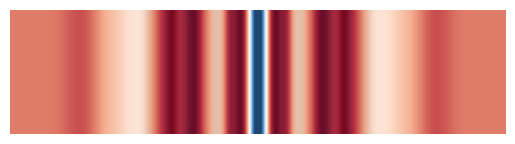

In [4]:
import matplotlib.pyplot as plt
eps_data = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Dielectric).reshape((-1,1))
ez_data = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Ez).reshape((-1,1))
plt.figure()
plt.imshow(eps_data.transpose(), extent=[0, 20, 0, 5], interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), extent=[0, 20, 0, 5], interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

## 3. Plot IR spectrum of liquid water

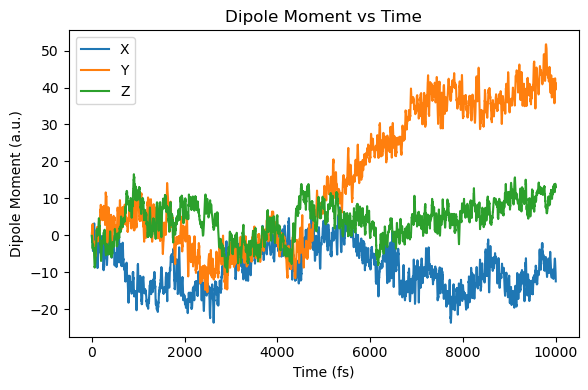

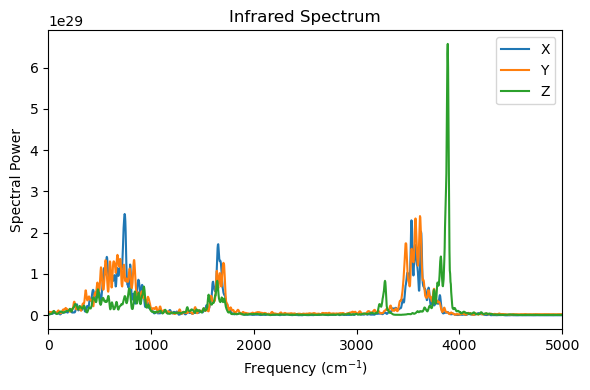

In [5]:
from maxwelllink.tools import ir_spectrum
import matplotlib.pyplot as plt

fs_to_au = 1 / 0.02418884254

mux = np.array([ad["mux_au"] for ad in molecule.additional_data_history])
muy = np.array([ad["muy_au"] for ad in molecule.additional_data_history])
muz = np.array([ad["muz_au"] for ad in molecule.additional_data_history])
t = np.array([ad["time_au"] for ad in molecule.additional_data_history]) / fs_to_au

plt.figure(figsize=(6, 4))
plt.plot(t, mux, label="X")
plt.plot(t, muy, label="Y")
plt.plot(t, muz, label="Z")
plt.xlabel("Time (fs)")
plt.ylabel("Dipole Moment (a.u.)")
plt.title("Dipole Moment vs Time")
plt.legend()
plt.tight_layout()
plt.show()

freq, sp_x = ir_spectrum(mux, 0.5*time_units_fs/resolution, field_description="square")
freq, sp_y = ir_spectrum(muy, 0.5*time_units_fs/resolution, field_description="square")
freq, sp_z = ir_spectrum(muz, 0.5*time_units_fs/resolution, field_description="square")

plt.figure(figsize=(6, 4))
plt.plot(freq, sp_x, label="X")
plt.plot(freq, sp_y, label="Y")
plt.plot(freq, sp_z, label="Z")
plt.xlim(0, 5000)
plt.xlabel("Frequency (cm$^{-1}$)")
plt.ylabel("Spectral Power")
plt.title("Infrared Spectrum")
plt.legend()
plt.tight_layout()

plt.show()



# 4. How to understand energy conservation?

We can also check energy conservation as below. 

**The energy of the molecular system is reduced** because the molecular system is continuously emitting EM field.

If the absorbing boundary conditions for the EM field are turned off (as in # geometry 2 in the first code block), i.e., using the geometry below instead of a Bragg resonator with absorbing boundary conditions (PML): 

```python
length = 0.5 * rescaling
cell_size = mp.Vector3(length, 0, 0)
geometry = []
pml_layers = []
```
energy conservation for the molecular system should be greatly improved. The readers may have a try.

**More importantly, when a larger water system is coupled to the cavity with a smaller rescaling factor**, the IR emission of the molecular system will be greatly reduced, thus also improving energy conservation in the molecular system.


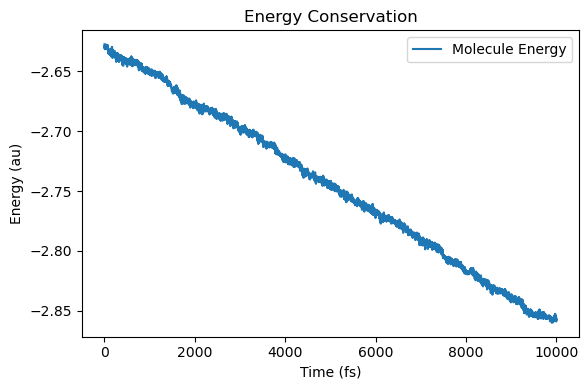

In [6]:
# also plot energy conservation dynamics
energy_molecule = np.array([ad["energy_au"] for ad in molecule.additional_data_history])

plt.figure(figsize=(6, 4))
plt.plot(t, energy_molecule, label="Molecule Energy")
plt.xlabel("Time (fs)")
plt.ylabel("Energy (au)")
plt.title("Energy Conservation")
plt.legend()
plt.tight_layout()
